Author: **Ivan Bongiorni**. 2020-03-23.

Repository: 

# Preliminary study of NaN distribution

This Notebook represents a "handmade" study I made before the actual model implementation. It is about how missing values are distributed in the dataset, and how their occurrence can be replicated. The artifical deterioration of trends is based on the evidence gathered.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn

In [2]:
path_to_data = 'C:/Users/ivan.bongiorni/Documents/timeseries/forecast/data/'

df = pd.read_csv(path_to_data + 'train_2.csv')

df.drop('Page', axis = 1, inplace = True)
df = df.values

In [3]:
def left_zero_fill(x):
    if np.isfinite(x[0]): 
        return x

    cumsum = np.cumsum(np.isnan(x))    
    x[ :np.argmax(cumsum[:-1]==cumsum[1:]) +1] = 0
    return x

for i in range(df.shape[0]):
    df[ i , : ] = left_zero_fill( df[ i , : ] )

In [4]:
# take rows with NaN's only
X = df[ np.isnan(df).any(axis=1)]

# Full trends
F = df[ ~np.isnan(df).any(axis=1)] 

In [5]:
print(X.shape) 

(18969, 803)


# Visual check of NaN distribution

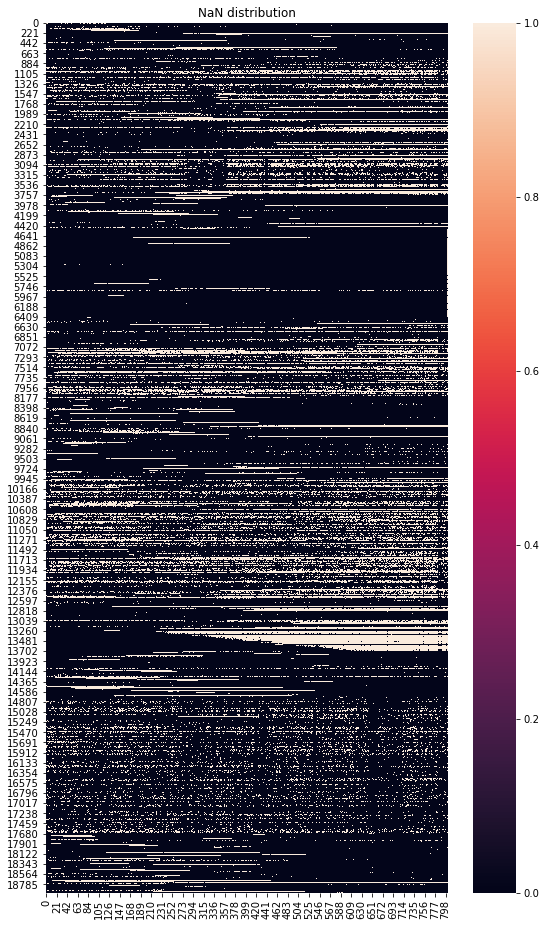

In [6]:
plt.figure(figsize=(9,16))
seaborn.heatmap(np.isnan(X))
plt.title('NaN distribution')
plt.show() 

It appears missing values appear in my dataset in two main ways:
- Pure random noise.
- A whole interval is "blank".

My deterioration function will have to replicate both.

In [7]:
# Plot distribution of NaN counts by row
nan_count = np.isnan(X).sum(axis=1) 

In [8]:
print(np.min(nan_count))
print(np.mean(nan_count))
print(np.max(nan_count))

1
120.75987136907587
781


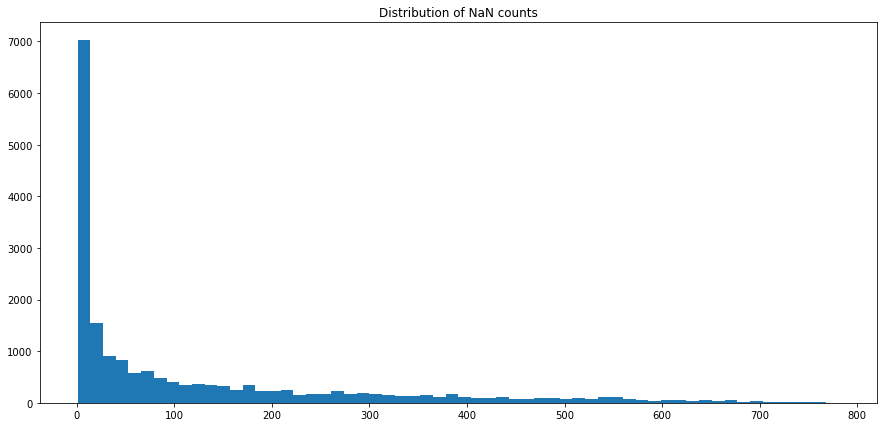

In [9]:
plt.figure(figsize=(15,7)) 
plt.hist(nan_count, bins = 60)
plt.title('Distribution of NaN counts')
plt.show() 

In [10]:
print(np.mean(nan_count))
print(np.std(nan_count)) 

120.75987136907587
165.49612703753957


In [11]:
# Generate distribution sampled from Exponential distribution
exp_draw = np.random.exponential(scale = np.std(nan_count), size = len(nan_count)) 

In [12]:
exp_draw[ exp_draw > np.max(nan_count) ] = 0

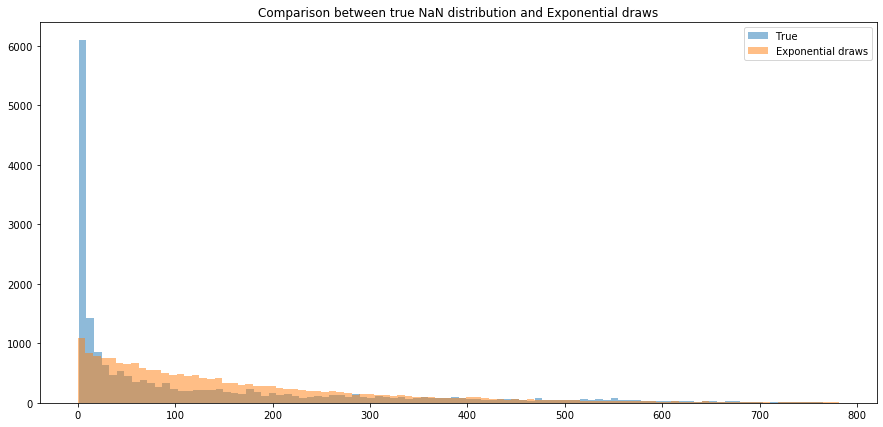

In [13]:
plt.figure(figsize=(15,7)) 
plt.hist(nan_count, bins = 100, label = 'True', alpha = 0.5)
plt.hist(exp_draw, bins = 100, label = 'Exponential draws', alpha = 0.5)
plt.title('Comparison between true NaN distribution and Exponential draws')
plt.legend()
plt.show() 

# Deterioration functions

I must apply two different kinds of artificial deterioration:
- Pure random perturbation - implemented in the form a Uniform and/or Gaussian draws.
- Random intervals of NaN's.

In [14]:
def exponential_noise(x, exp_scale):
    ''' Samples the number of NaN's in x from Exponential distribution; 
    determines their position in the trend; masks actual trend. '''
    import numpy as np
    
    # determine number of NaN's and their position
    nan_number = round(np.random.exponential(scale = exp_scale))
    # nan_draw = np.random.choice([0, 1], size = len(x)) 
    nan_idx = np.random.randint(low = 0, high = len(x), size = nan_number)
    
    x[ nan_idx ] = np.nan
    return x

def blank_random_interval(x, min_size, max_size):
    ''' Draws a blank interval size and its position. '''
    import scipy
    width = int(len(x) * np.random.uniform(min_size, max_size))
    where = np.random.randint(low = 0, high = len(x)-width)
    x[ where:where+width ] = np.nan
    return x

def deteriorate(x, params):
    '''
    Applies random artificial deteriorations. The first coin flip
    determines application of random noise. The second determines 
    the addition of a blank interval. Else applies both.
    '''
    
    if np.random.choice([0, 1], p = [1-params['prob_noise'], params['prob_noise']]):
        x = exponential_noise(x, exp_scale = params['exp_scale'])
    
    elif np.random.choice([0, 1], p = [1-params['prob_interval'], params['prob_interval']]):
        x = blank_random_interval(x, 
                                  min_size = params['interval_ratio'][0], 
                                  max_size = params['interval_ratio'][1])
    else: 
        x = exponential_noise(x, exp_scale = params['exp_scale'])
        x = blank_random_interval(x, 
                                  min_size = params['interval_ratio'][0], 
                                  max_size = params['interval_ratio'][1])
    return x

In [15]:
params = {
    'prob_noise': 0.75,
    'exp_scale': 165.496,  # np.std(nan_count)
    'interval_ratio': [0.01, 0.4],
    'prob_interval': 0.5
} 

In [16]:
# Make a copy of X and check artificial deterioration
Z = np.copy(F) 

for i in range(Z.shape[0]):
    Z[ i , : ] = deteriorate(Z[ i , : ], params) 


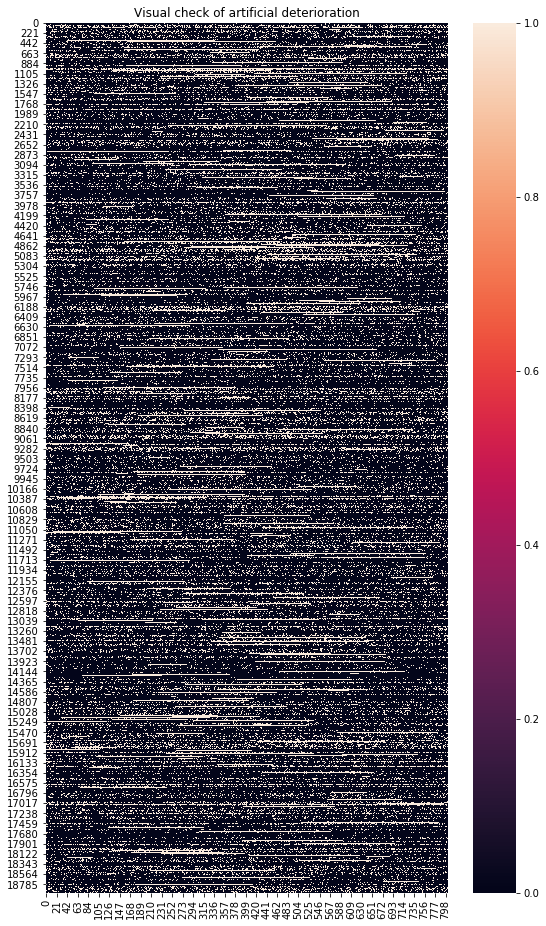

In [17]:
plt.figure(figsize=(9,16))
seaborn.heatmap(np.isnan(Z[ 0:X.shape[0] , : ]))
plt.title('Visual check of artificial deterioration')
plt.show() 

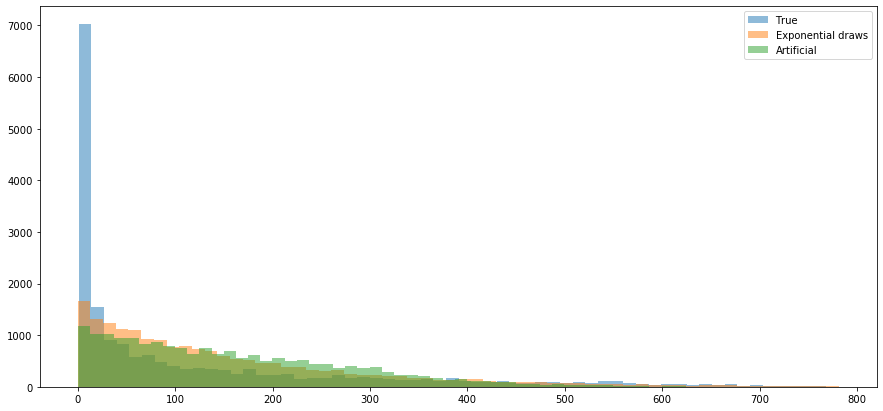

In [18]:
artificial_nan_count = np.isnan(Z).sum(axis=1) 

plt.figure(figsize=(15,7)) 
plt.hist(nan_count, bins = 60, label = 'True', alpha = 0.5)
plt.hist(exp_draw, bins = 60, label = 'Exponential draws', alpha = 0.5)
plt.hist(artificial_nan_count[ 0:len(nan_count) ], bins = 60, label = 'Artificial', alpha = 0.5)
plt.legend()
plt.show() 

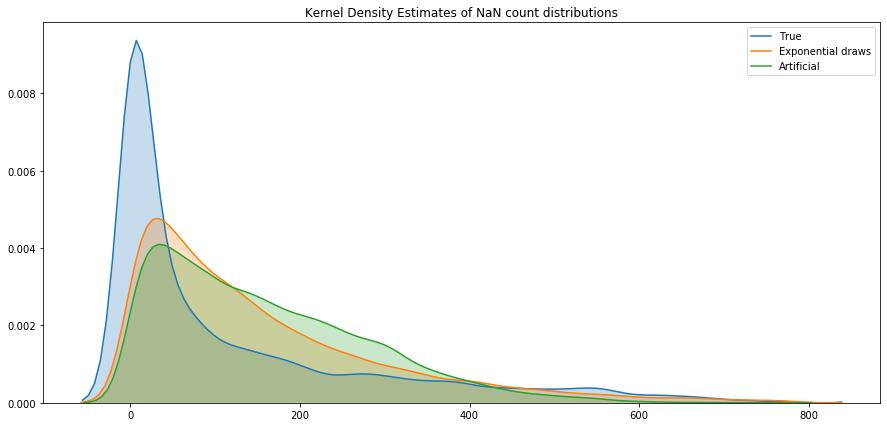

In [19]:
plt.figure(figsize=(15,7)) 
seaborn.kdeplot(nan_count, shade = True, label = 'True')
seaborn.kdeplot(exp_draw, shade = True, label = 'Exponential draws')
seaborn.kdeplot(artificial_nan_count[:len(nan_count)], shade = True, label = 'Artificial')
plt.title('Kernel Density Estimates of NaN count distributions')
plt.legend()
plt.show() 

# Examples

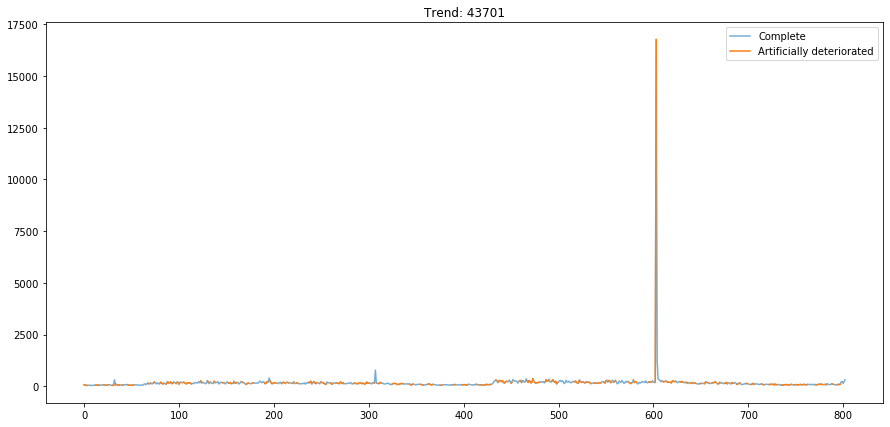

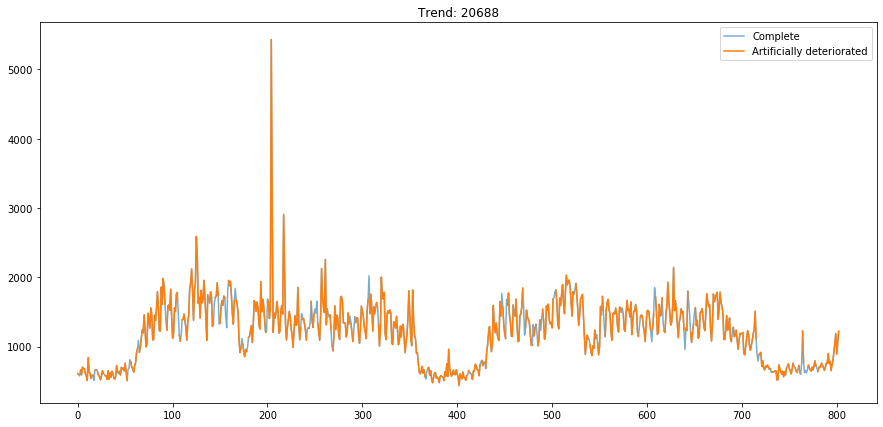

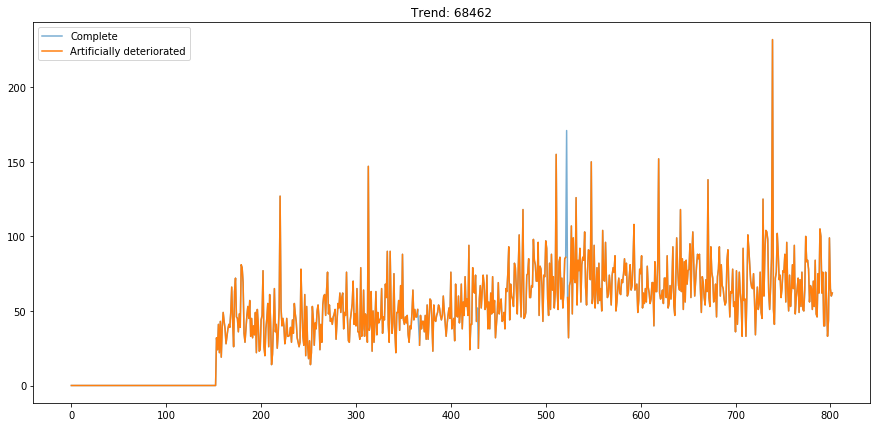

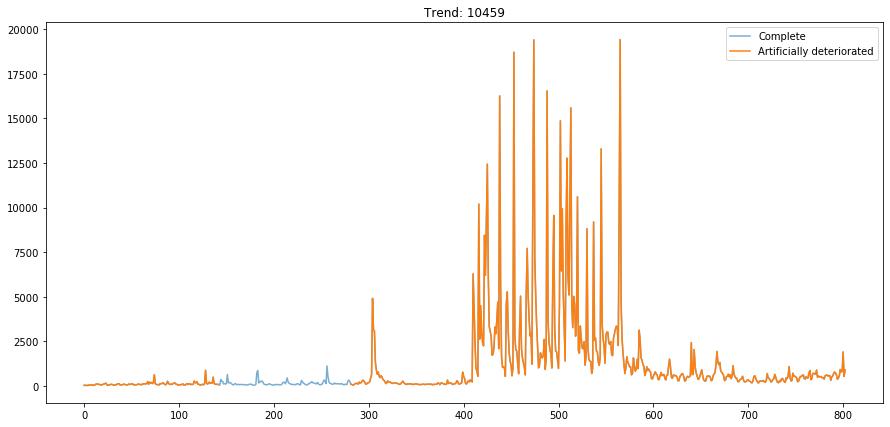

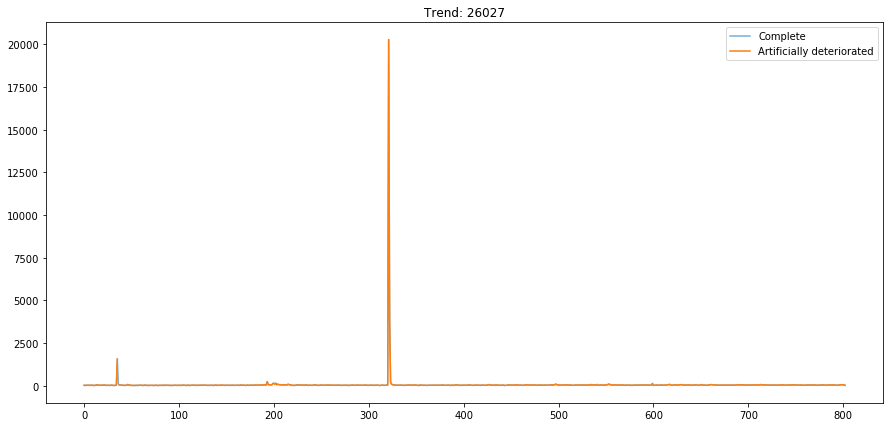

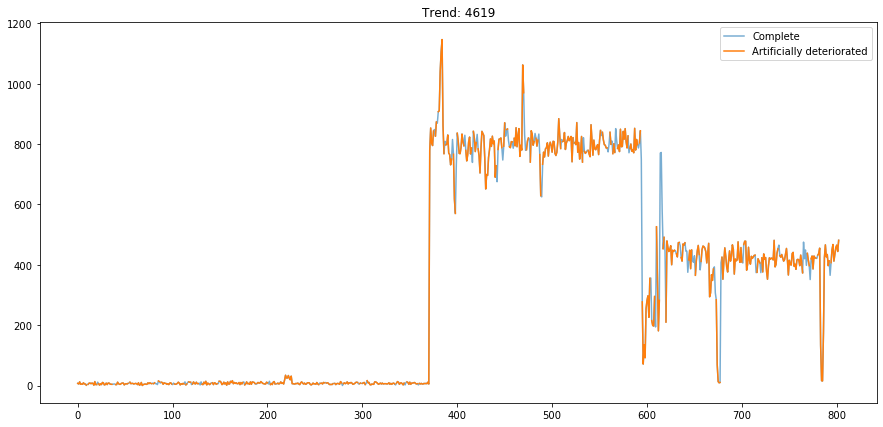

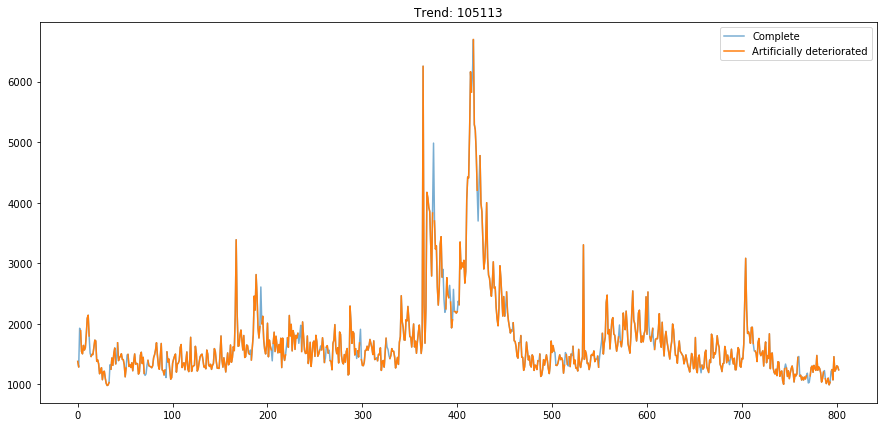

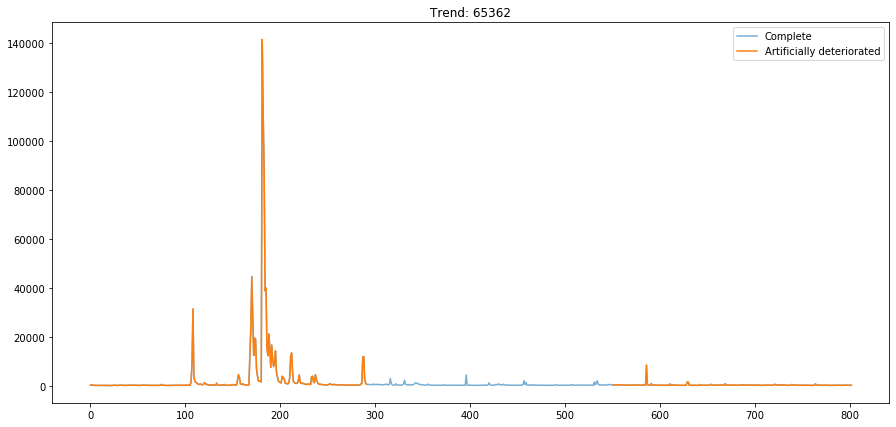

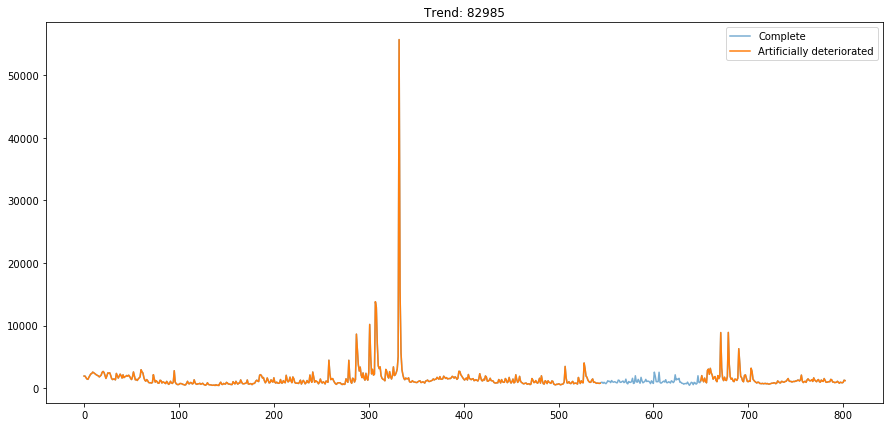

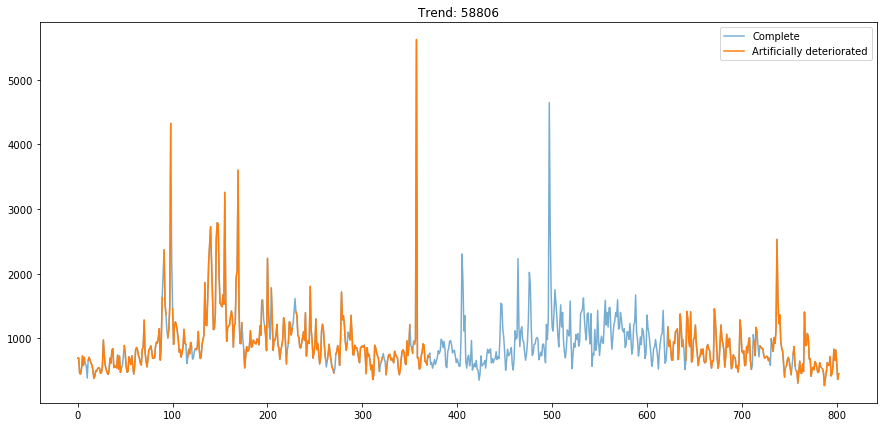

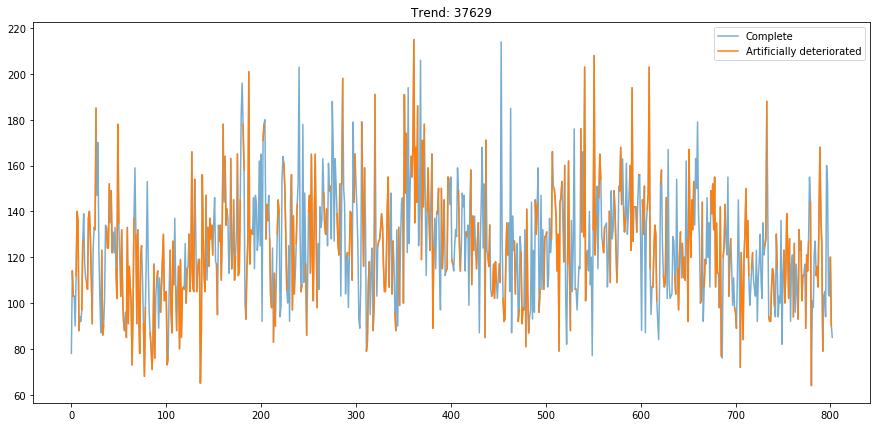

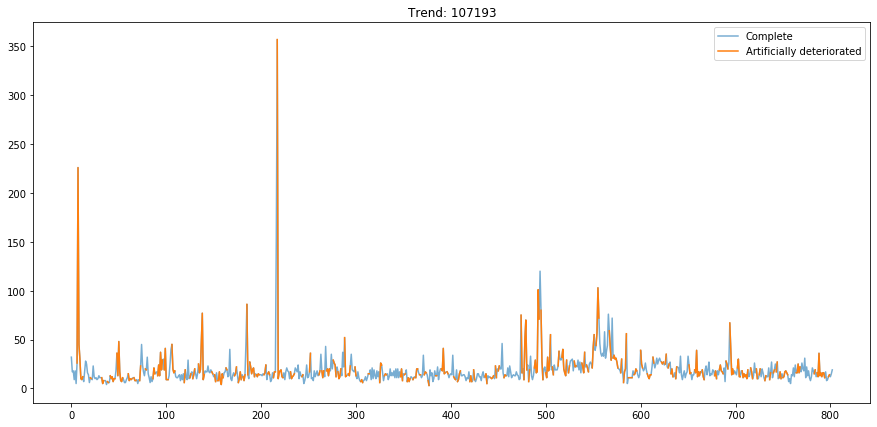

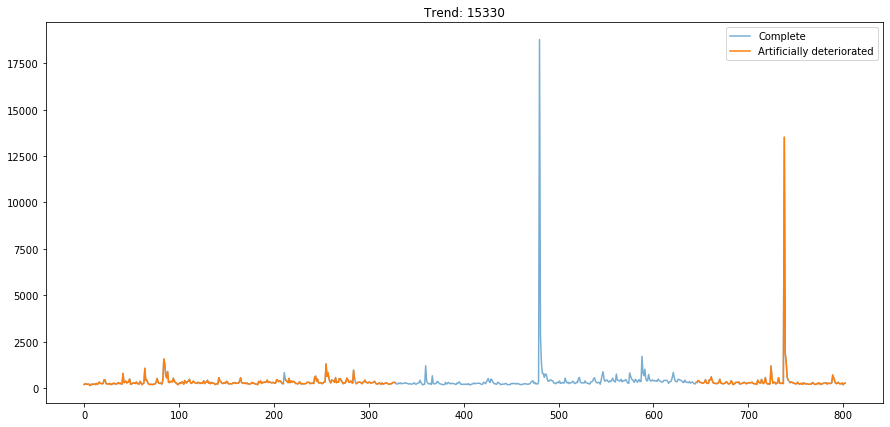

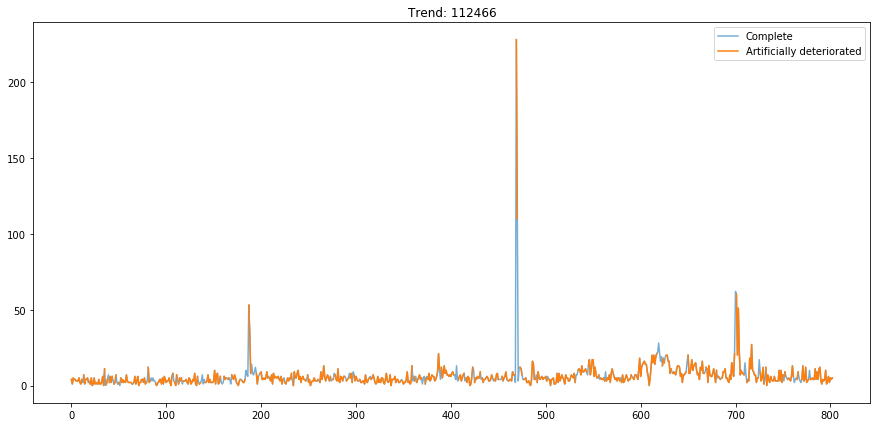

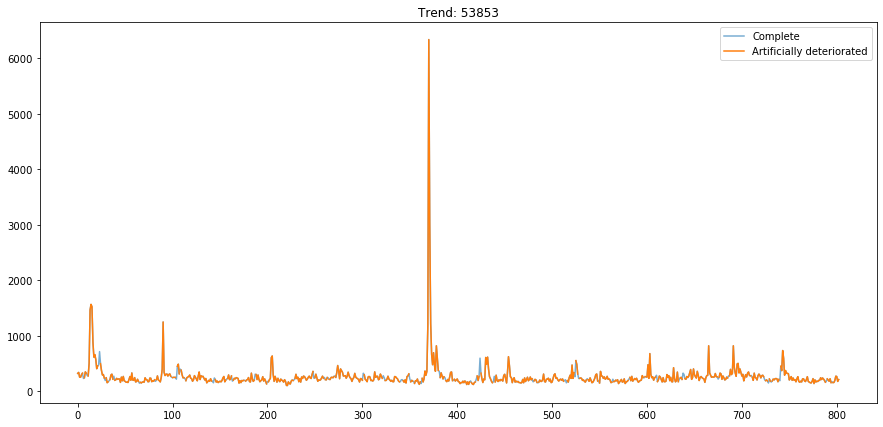

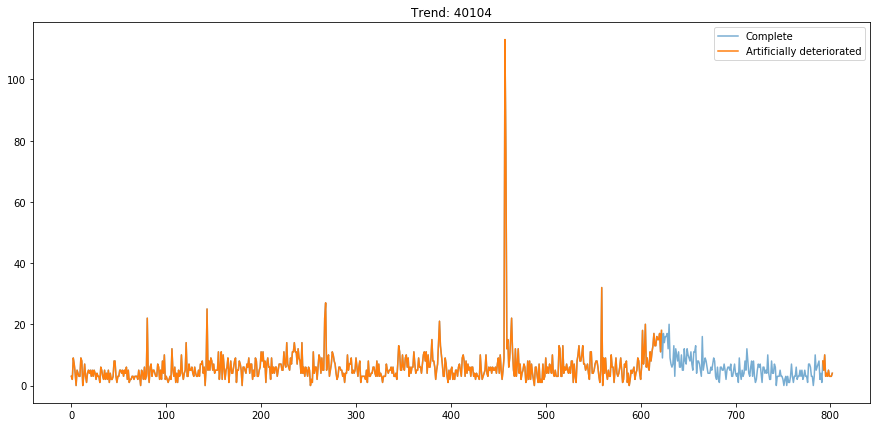

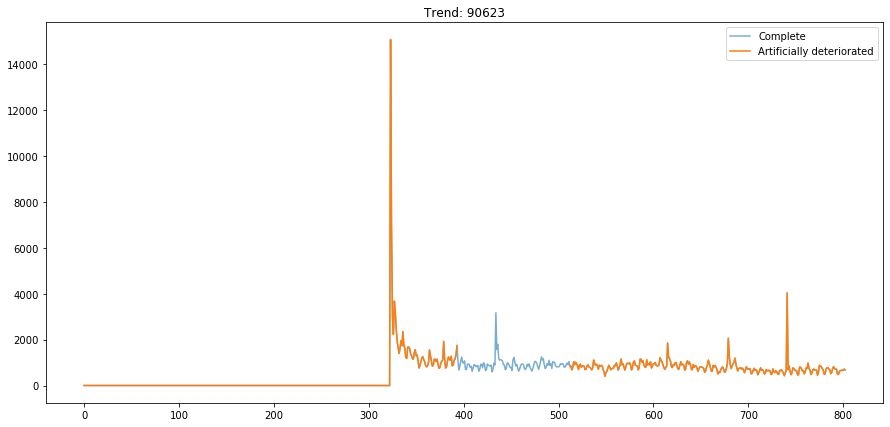

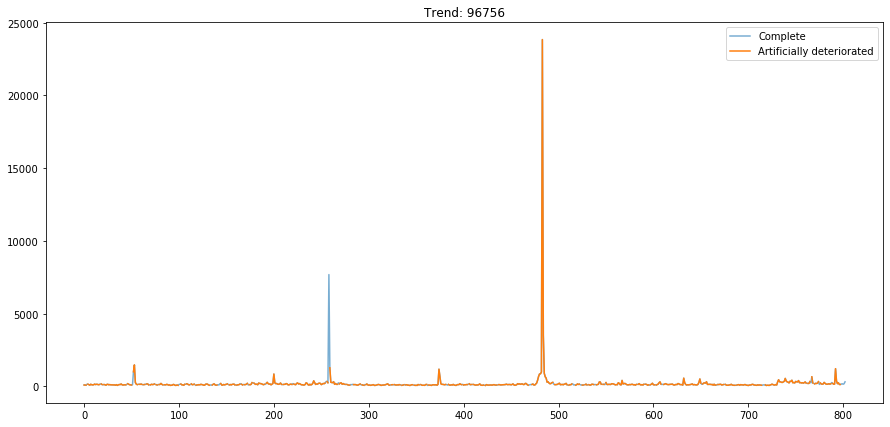

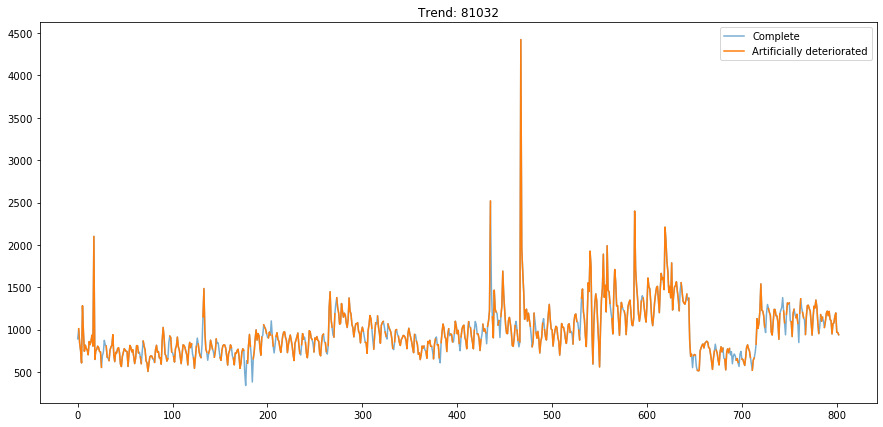

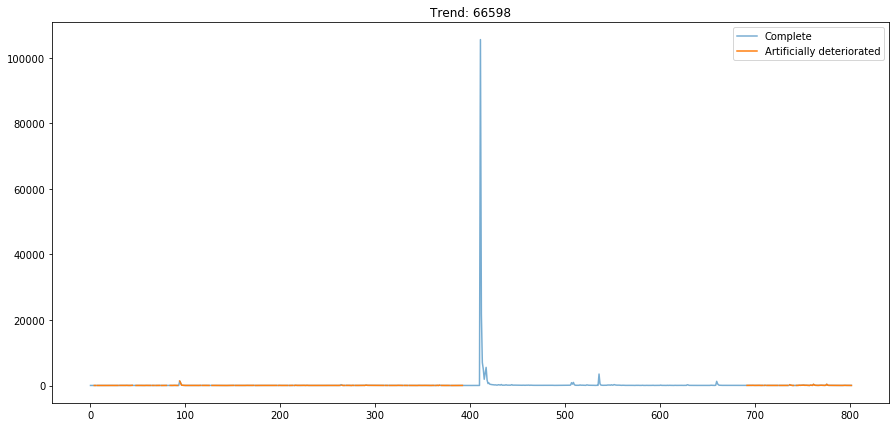

In [20]:
for _ in range(20):
    idx = np.random.randint(0, len(F))
    
    plt.figure(figsize=(15,7)) 
    plt.plot( F[ idx , : ], label = 'Complete')
    plt.plot( Z[ idx , : ], label = 'Artificially deteriorated' )
    plt.title('Trend: {}'.format(idx))
    plt.legend()
    plt.show() 